## Problem Description

### Dataset

In this example, we will be working on the Fed-IXI dataset from [FLamby](https://arxiv.org/pdf/2210.04620), which contains brain T1 magnetic resonance images (MRIs) from 3 hospitals. The statistics of the data from three hospitals are as follows. The data from each hospital are randomly split into a training set (80% of data) and a test set (20% of data). **This notebook represents the Hammersmith Hospital (HH).**

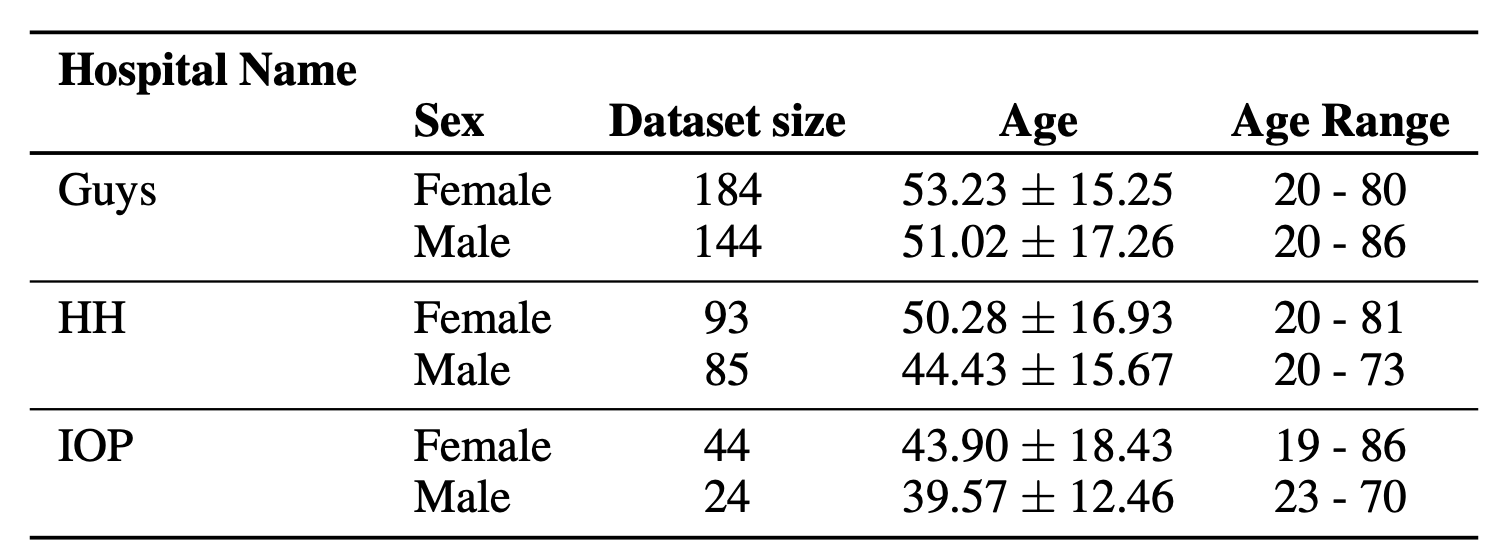

Below image shows the MRI intensity distribution for the images from the three different hospitals, which indicates that each client has a different intensity profile and the data are very heterogeneous.

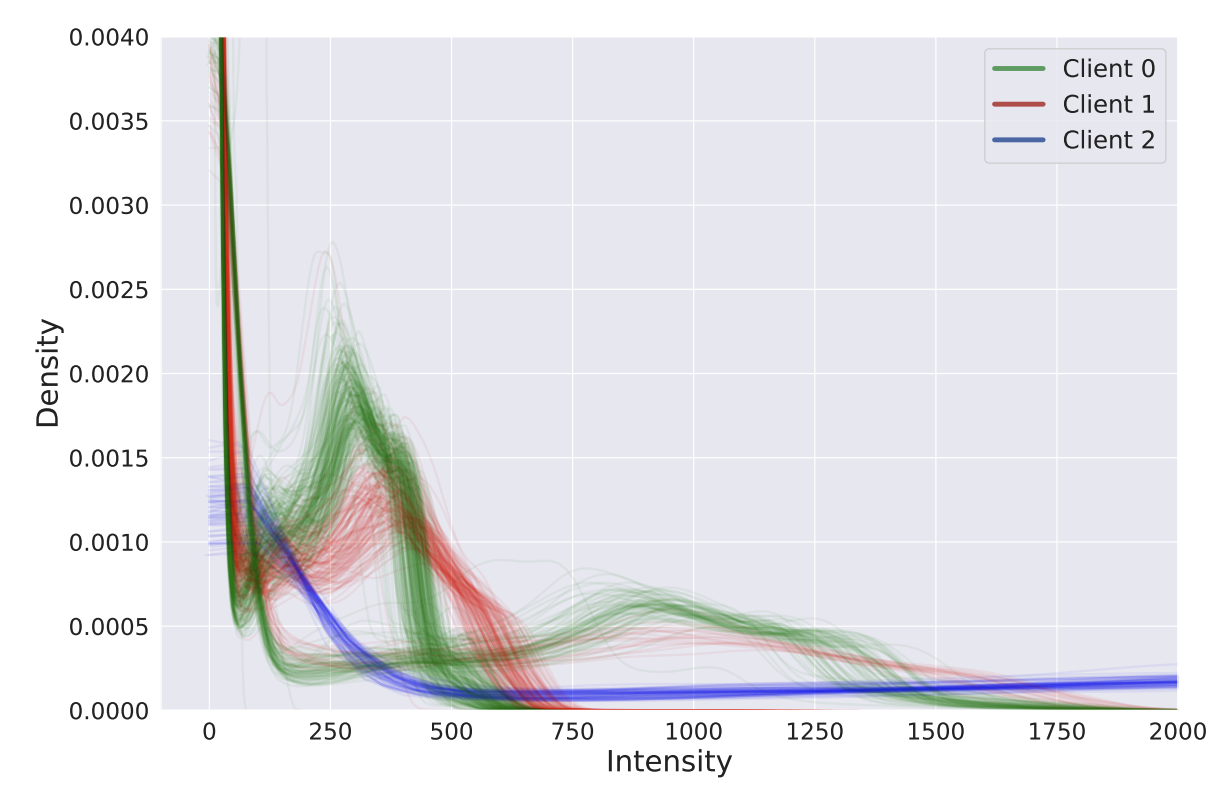

### Dataset Pollution

In this example, we will be using a modified version of the Flamby IXI dataset, **in which a subset of samples has been deliberately altered by adding Gaussian noise.** This simulates a data pollution scenario. Later in the tutorial, we will demonstrate how APPFL provides a dedicated module within its framework to address such data readiness challenges.


### Training Goal

In this example, all the MRIs are preprocessed to get sized to 48×60×48 voxels. The training goal is to segment the pixels from other head components, such as eyes, skin, and fat. To do supervised training, the corresponding brain image binary segmentation masks are given are labels. 

### Training Loss

In this example, we use **Dice Loss**, a loss function commonly used in **image segmentation tasks**, particularly in **medical imaging**. It is based on the **Dice Similarity Coefficient (DSC)**, which measures the overlap between predicted and ground truth segmentation masks.

**Dice Coefficient Formula:**

$$
\text{Dice}(P, G) = \frac{2|P \cap G|}{|P| + |G|} = \frac{2 \sum_i p_i g_i}{\sum_i p_i + \sum_i g_i}
$$

- $P$: predicted binary mask  
- $G$: ground truth binary mask  
- $p_i, g_i \in \{0, 1\}$

**Dice Loss:**

$$
\text{Dice Loss} = 1 - \text{Dice}(P, G)
$$

For numerical stability (to avoid division by zero), a small epsilon is often added:

$$
\text{Dice Loss} = 1 - \frac{2 \sum_i p_i g_i + \epsilon}{\sum_i p_i + \sum_i g_i + \epsilon}
$$

### Training Settings

We use a [UNet](https://arxiv.org/pdf/1505.04597) model taking the individual T1 image as input, to predict the associated binary brain mask. The UNet model is a standard type of convolution neural network architecture commonly used in biomedical image segmentation tasks. It is specifically used to perform semantic segmentation, meaning that each voxel of the image volume is classified. 

The UNet is optimized with a batch size of 2 and a learning rate of $10^{−3}$ with the AdamW optimizer.

In [ ]:
# [WARNING]: Please only run this cell ONCE at the beginning of your script.
# First: Change the working directory to the root of the repository and ignore warnings
import os
import warnings

os.chdir("../..")
warnings.filterwarnings("ignore")

In [ ]:
# Set seed for reproducibility
import torch
import random
import numpy as np

seed_value = 1

random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Load training configuration to train model on HH's data directly

We load all necessary configurations needed for training the model using HH's data, including training settings, model definition file, and data loading file.

In [ ]:
from omegaconf import OmegaConf
from appfl.agent import ClientAgent

hh_config = OmegaConf.load("./resources/configs/flamby/ixi/hh_local.yaml")
print("==========Training Configuration==========")
print(OmegaConf.to_yaml(hh_config))
print("========================================")

### Start training on HH's data

We can create an agent provided by the `appfl` package, which can be initiated using the loaded configuration and contains a `train()` function to do the training.

In [ ]:
hh_agent = ClientAgent(client_agent_config=hh_config)

num_of_epoch = 10
for i in range(0, num_of_epoch):
    hh_agent.train()

### Understanding from above experiment

What if two hospitals (HH and IOP) were able to collaborate to train a model? It would likely result in a better-generalized model with more training data. However, sharing hospital data is not that simple due to privacy, security, and regulatory concerns. This is where Federated Learning comes into play — it allows institutions to collaboratively train a model without actually sharing their data.

## From local training to federated learning using APPFL


<img src="https://github.com/APPFL/APPFL/blob/main/docs/_static/logo/logo_small.png?raw=true" width="40%" alt="APPFL Logo">


In this tutorial, we will leverage the Advanced Privacy-Preserving Federated Learning ([APPFL](https://github.com/APPFL/APPFL)) framework to launch a federated learning client for running a federated learning experiment with two clients and one central server. The server launching code is available in your workspace as **APPFL_Server_IXI.ipynb**. Please make sure you first launch the server before launching this client.

### 1. Introduction to Federated Learning

As shown in the figure below, federated learning can be understood as a distributed version of traditional machine by iterating the following two steps after a model initialization step

(1) Each client trains an ML model using its local dataset and submits the updated model to the server.

(2) The server aggregates these local models to update the global model and then sends it back to the clients for further local training.

As only model parameters are exchanged, federated learning offers a promising solution to utilize data from multiple data owners without direct data sharing, and it can usually help with training more robust, generalized, and powerful model by leveraging more training data.

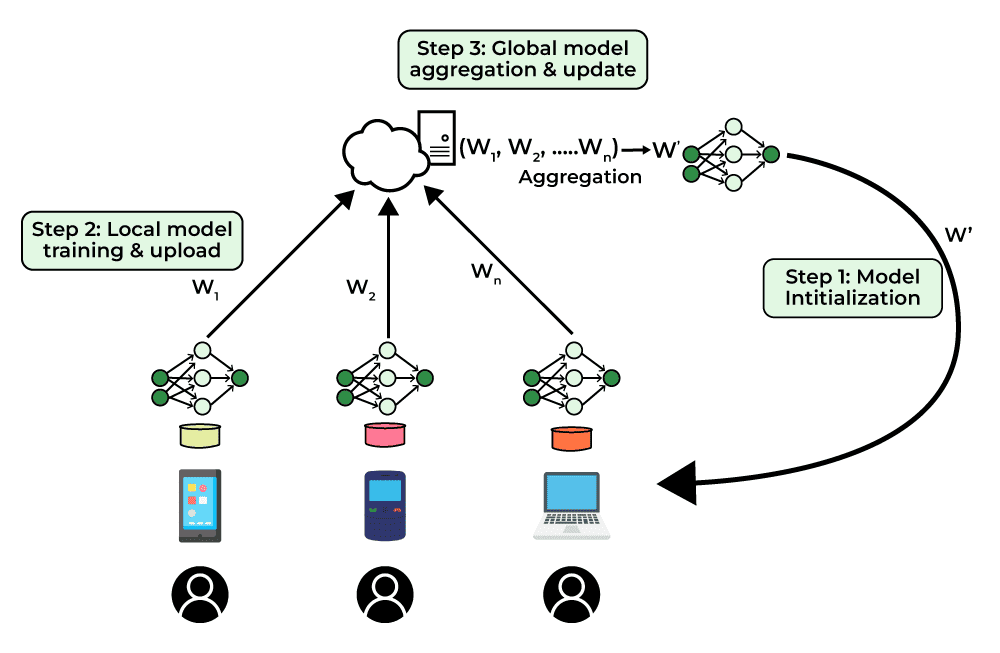

### 2. Create federated learning client agent from configurations

We need to update the `server_uri` to the URL obtained from the **server** notebook.

#### Steps:

- ##### Obtain the `server` URL:
  - For example, the server URL from the server notebook is `172.31.79.131:50051`.

- ##### Update the code:
  - Replace the placeholder in the following line with the actual `server` URL obtained.

  - Update the code as follows:
`client_agent_config.comm_configs.grpc_configs["server_uri"] = "172.31.79.131:50051"`

In the client configurations, it has four main parts:

- `client_id`: A unique identifier for the client
- `train_configs`: Client-specific training related configurations, such as the device and logging directories
- `data_configs`: Information about the dataloader file that can create a PyTorch dataset for the IXI data
- `comm_configs`: Information needed to connect to the server notebook

In [ ]:
client_agent_config = OmegaConf.load(
    "./resources/configs/flamby/ixi/client_1_polluted.yaml"
)
client_agent_config.comm_configs.grpc_configs["server_uri"] = (
    "128.55.70.167:50051"  # Reminder: Replace this with the URI you got from the server notebook!
)
print("==========Client Configuration==========")
print(OmegaConf.to_yaml(client_agent_config))
print("========================================")
client_agent = ClientAgent(client_agent_config=client_agent_config)

### 3. Create Client Communicator

Now, we create a grpc client communicator for sending various requests to the server.

In [ ]:
from appfl.comm.grpc import GRPCClientCommunicator

client_communicator = GRPCClientCommunicator(
    client_id=client_agent.get_id(),
    **client_agent_config.comm_configs.grpc_configs,
)

### 4. Start training loop by sending requests to server.

In this main training loop, it has four main types of request to send to the server:

(1) `get_configuration()`: Get general client configurations for local training

(2) `get_global_model(init_model=True)`: Get the initial global model for training

(3) `update_global_model()`: Send the trained local model to update the global model, and get the updated model back for further local training

(4) `invoke_custom_action(action="close_connection")`: Close the connection with the server

In [ ]:
# Get general client configurations
client_config = client_communicator.get_configuration()
client_agent.load_config(client_config)

# Get initial global model parameters
init_global_model = client_communicator.get_global_model(init_model=True)
client_agent.load_parameters(init_global_model)

# Start local training loop
while True:
    client_agent.train()
    local_model, metadata = client_agent.get_parameters()
    new_global_model, metadata = client_communicator.update_global_model(
        local_model, **metadata
    )
    if metadata["status"] == "DONE":
        break
    client_agent.load_parameters(new_global_model)

# Close connection
client_communicator.invoke_custom_action(action="close_connection")

## Improve Model Performance by Data Readiness Evaluation

Data quality is essential for the performance of trained AI models. Now, we leverage the Customizable Assurance of Data REadiness (CADRE) module to improve the data quality of two clients' local training data. The CADRE module defines metrics used to measure the data quality, the rules the measured metric are supposed to follow, and the remedy action to take for data that do not follow the rules. For more detailed information on how to use and configure the CADRE module, please refer to [this tutorial](https://appfl.ai/en/latest/tutorials/examples_dr_integration.html). In this case study, we defined a CADRE module to remove images with noisy samples from the clients' local dataset.

In addition to data preprocessing based on CADRE, we also generate a data readiness report for the processed data here.

### 1. Create a new client agent and communicator

Similar as before, we need to create a new client agent and communicator, and then communicate with the server. The server will provide a new configuration file for the client that specifies how to process and evaluate the data readiness.

**Note: Make sure to start the second server from the server notebook before running the following cell.**

In [ ]:
client_agent_config = OmegaConf.load(
    "./resources/configs/flamby/ixi/client_1_polluted.yaml"
)
client_agent_config.comm_configs.grpc_configs["server_uri"] = (
    "128.55.70.167:50051"  # Reminder: Replace this with the URI you got from the server notebook!
)
print("==========Client Configuration==========")
print(OmegaConf.to_yaml(client_agent_config))
print("========================================")
client_agent = ClientAgent(client_agent_config=client_agent_config)
client_communicator = GRPCClientCommunicator(
    client_id=client_agent.get_id(),
    **client_agent_config.comm_configs.grpc_configs,
)

### 2. Get new configuration and process the data

Now, the client sends requests to get new configuration and starts data processing and evalution.

In [ ]:
# Get general client configurations
client_config = client_communicator.get_configuration()
client_agent.load_config(client_config)

# Generate data readiness report
if (
    hasattr(client_config, "data_readiness_configs")
    and hasattr(client_config.data_readiness_configs, "generate_dr_report")
    and client_config.data_readiness_configs.generate_dr_report
):
    # Check CADREModule availability and if the data needs remediation
    if (
        hasattr(client_config.data_readiness_configs.dr_metrics, "cadremodule_configs")
        and hasattr(
            client_config.data_readiness_configs.dr_metrics.cadremodule_configs,
            "remedy_action",
        )
        and client_config.data_readiness_configs.dr_metrics.cadremodule_configs.remedy_action
    ):
        client_agent.adapt_data(client_config=client_config)
    data_readiness = client_agent.generate_readiness_report(client_config)
    client_communicator.invoke_custom_action(
        action="get_data_readiness_report", **data_readiness
    )

### 3. Start a new training loop using the updated dataset

In [ ]:
# Get initial global model parameters
init_global_model = client_communicator.get_global_model(init_model=True)
client_agent.load_parameters(init_global_model)

# Start local training loop
while True:
    client_agent.train()
    local_model, metadata = client_agent.get_parameters()
    new_global_model, metadata = client_communicator.update_global_model(
        local_model, **metadata
    )
    if metadata["status"] == "DONE":
        break
    client_agent.load_parameters(new_global_model)

# Close connection
client_communicator.invoke_custom_action(action="close_connection")